In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from nltk.corpus import stopwords
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.pipeline import make_pipeline

In [2]:
# Import the data
true0 = pd.DataFrame(pd.read_csv('./true.csv'))
fake0 = pd.DataFrame(pd.read_csv('./fake.csv'))

In [3]:
true0.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [4]:
fake0.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [5]:
fake_politics = fake0[fake0.subject.isin(['Government News', 'politics'])]
true_politics = true0[true0.subject == 'politicsNews']

In [6]:
# Filter the news of 2016
fake_politics_2016 = fake_politics[fake_politics['date'].str.contains('2016')]
true_politics_2016 = true_politics[true_politics['date'].str.contains('2016')]
fake1 = fake_politics_2016
true1 = true_politics_2016
fake1['label']=0
true1['label']=1

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [7]:
# Combine both true news and fake news published in 2016
news=fake1.append(true1)
news.head()

,title,text,subject,date,label
12023,TRUMP DITCHES PRESS To Make “Last Minute” Surp...,President-elect Donald Trump played a round of...,politics,"Dec 31, 2016",0
12024,"COUNTDOWN TICKER: Obama Leaves Office In…5,4,3...",(function(){ var s=document.createElement('scr...,politics,"Dec 31, 2016",0
12025,BOOM! TOMI LAHREN’S Top Tips For Liberals In 2...,,politics,"Dec 31, 2016",0
12026,"YES, OBAMA…There Is A Magic Wand! [Video]",,politics,"Dec 31, 2016",0
12027,HA! DONALD TRUMP’S Unusual New Year’s Tweet To...,President-elect Donald Trump is throwing a pri...,politics,"Dec 31, 2016",0


In [8]:
# Import stopword set
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Define a series of data cleaning functions
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing punctuation
def remove_punctuation(text):
    pattern = '[’!"#$%&\'()*+,-./:;<=>?@[\\]"^_`{|}~]+' 
    text = re.sub(pattern,'',text)
    return text

#Since 'reuters' is shown in almost every piece of true news, we want to remove it from the true news
def remove_reuters(text):
    if 'reuters' in text.split()[0:5]:
        text = text[text.find('reuters'):]
        text = text.split(' ', 1)[1]
    return text
    

#Removing the noisy text
def denoise_text(text):
    text.lower()
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_reuters(text)
      
    return text


In [10]:
#Apply functions on text and title columns
news['text']=news['text'].apply(denoise_text)
news['title']=news['title'].apply(denoise_text)

C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=IioEIUmawRo" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=31MRqr9ydUU" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=wYdX071Nlow" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the doc

In [11]:
# drop those empty text data 
news = news[news.text != '']
# Shuffle the news
news = news.sample(frac = 1, random_state = 1)
news.head(10)

,title,text,subject,date,label
9917,mississippi governor signs law allowing armed ...,mississippi governor phil bryant signed gun ri...,politicsNews,"April 15, 2016",1
13107,watch cnn host freak onair “factcheck” proves ...,hangon hangon hangon hangon brooke baldwin des...,politics,"Sep 2, 2016",0
10519,kerry trip cuba rights dialogue canceled us of...,tentative plans us secretary state john kerry ...,politicsNews,"March 4, 2016",1
10945,special report obama gun control advocates sto...,barack obama might seem unlikely investor fire...,politicsNews,"February 5, 2016",1
10495,white house adviser rhodes meet cuban american...,president barack obamas deputy national securi...,politicsNews,"March 4, 2016",1
8137,us lawmakers say afghanistan corruption threat...,us senators questioned state department offici...,politicsNews,"September 15, 2016",1
14256,unhinged radical leftists try storm trumps uta...,utah protest planned organized far left effort...,politics,"Mar 19, 2016",0
13814,five state department rules hillary violated,hillary doubles false claim rules clarified le...,politics,"May 27, 2016",0
14165,witch hunt communist california raids home man...,make mistake it seeing tactics used communist ...,politics,"Apr 6, 2016",0
14448,gag hollywood latinos gush hillary nevada race...,pandering hillary best first black vote meetin...,politics,"Feb 20, 2016",0


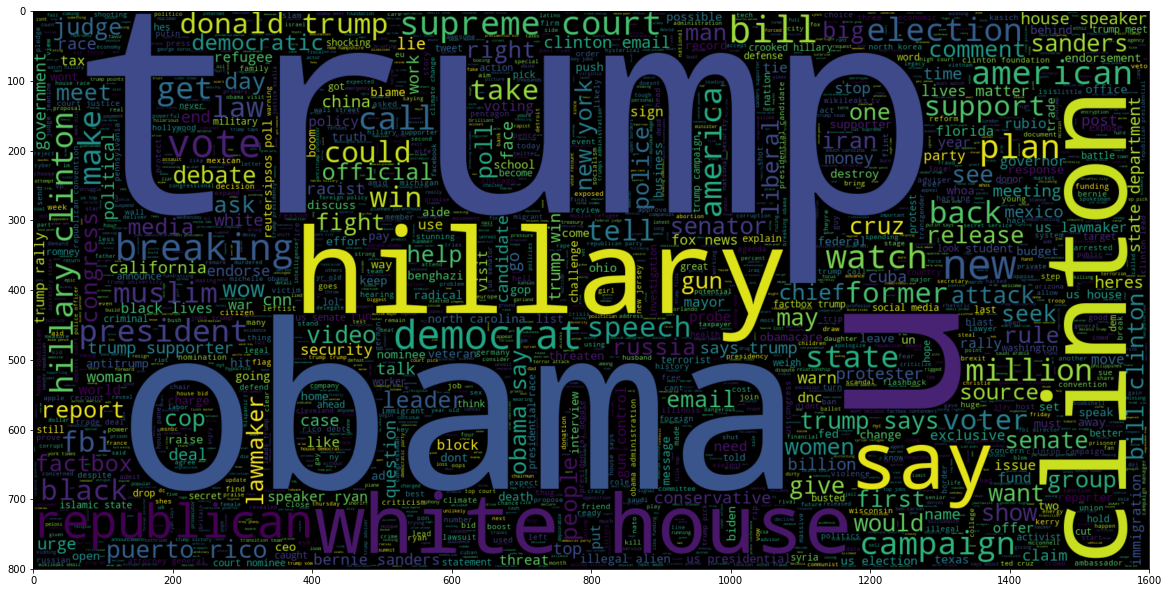

In [12]:
# Wordcloud of the titles of all news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(news.title))
plt.imshow(wc , interpolation = 'bilinear')

Text(0.5, 1.0, 'Counts of fake news and true news in the dataframe')

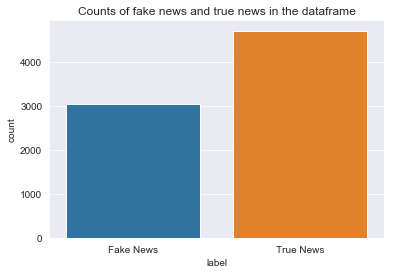

In [13]:
# To show the counts of fake news and true news in the dataframe
sns.set_style("darkgrid")
name = ['Fake News', 'True News']
a = sns.countplot(news.label)
a.set_xticklabels(name)
a.set_title("Counts of fake news and true news in the dataframe")

Text(0.5, 1.0, 'Distribution of number of words in each title')

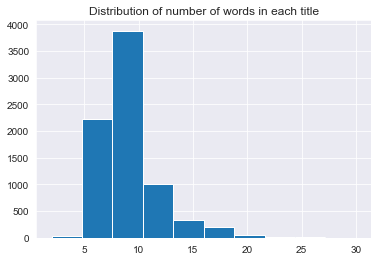

In [14]:
# Analyze the distribution of number of words in each title
len_title = [len(i.split()) for i in news['title']]
b = plt.hist(len_title)
plt.title("Distribution of number of words in each title")

Text(0.5, 1.0, 'Boxplot of number of words in each text')

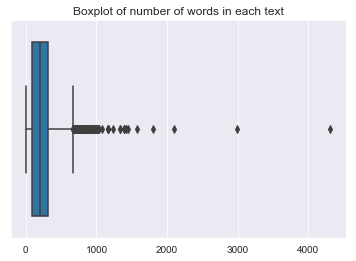

In [15]:
# Analyze the number of words in each text
len_text = [len(i.split()) for i in news['text']]
sns.boxplot(len_text).set_title("Boxplot of number of words in each text")

In [16]:
# Choose the title and text columns and split the data
X = news[['title', 'text']]
Y = news[['label']]
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)

In [17]:
# Split the data as two sources: title and text 
x_train_title = x_train['title']
x_train_text = x_train['text']
x_test_title = x_test['title']
x_test_text = x_test['text']

y_train = y_train['label']
y_test = y_test['label']

# Part 1. Prediction based on Title

# Model1: Naive Bayes Model with TF-IDF inputs

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

In [19]:
model1_title = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_title.fit(x_train_title, y_train)
pred1_title = model1_title.predict(x_test_title)
f1_model1_title = f1_score(y_test, pred1_title, average = 'macro')

print('F1 score of model1_title:', f1_model1_title)

F1 score of model1_title: 0.9281289373295099


Text(28.6, 0.5, 'predicted label')

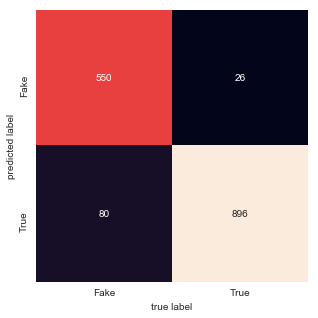

In [20]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_title)
label_name = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


# Model 2: Single Layer Dense Neural Network (DNN) Model with TF-IDF Inputs

In [21]:
from sklearn.neural_network import MLPClassifier

model2_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ),random_state=1, verbose = True))
model2_title.fit(x_train_title, y_train)

Iteration 1, loss = 0.67931797
Iteration 2, loss = 0.58607968
Iteration 3, loss = 0.45919279
Iteration 4, loss = 0.33990822
Iteration 5, loss = 0.25078905
Iteration 6, loss = 0.18947957
Iteration 7, loss = 0.14758040
Iteration 8, loss = 0.11841614
Iteration 9, loss = 0.09669657
Iteration 10, loss = 0.08061329
Iteration 11, loss = 0.06804653
Iteration 12, loss = 0.05814917
Iteration 13, loss = 0.05024183
Iteration 14, loss = 0.04372418
Iteration 15, loss = 0.03837055
Iteration 16, loss = 0.03390911
Iteration 17, loss = 0.03015030
Iteration 18, loss = 0.02696851
Iteration 19, loss = 0.02423972
Iteration 20, loss = 0.02190843
Iteration 21, loss = 0.01992083
Iteration 22, loss = 0.01814972
Iteration 23, loss = 0.01662708
Iteration 24, loss = 0.01528897
Iteration 25, loss = 0.01409501
Iteration 26, loss = 0.01302000
Iteration 27, loss = 0.01207480
Iteration 28, loss = 0.01121923
Iteration 29, loss = 0.01049916
Iteration 30, loss = 0.00979514
Iteration 31, loss = 0.00917126
Iteration 32, los

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False))])

In [22]:
pred2_title = model2_title.predict(x_test_title)
f1_model2_title = f1_score(y_test, pred2_title, average = 'macro')
print('F1 score of model2_title:', f1_model2_title)

F1 score of model2_title: 0.9431500606551619


# Model 3: Multi Layer DNN Model with TF-IDF inputs

In [23]:
model3_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(200,200,200,200, ),random_state=1, verbose = True))
model3_title.fit(x_train_title, y_train)

Iteration 1, loss = 0.58296919
Iteration 2, loss = 0.10330109
Iteration 3, loss = 0.01375077
Iteration 4, loss = 0.00168248
Iteration 5, loss = 0.00049345
Iteration 6, loss = 0.00030998
Iteration 7, loss = 0.00025794
Iteration 8, loss = 0.00023576
Iteration 9, loss = 0.00022034
Iteration 10, loss = 0.00020969
Iteration 11, loss = 0.00020404
Iteration 12, loss = 0.00020012
Iteration 13, loss = 0.00019695
Iteration 14, loss = 0.00019417
Iteration 15, loss = 0.00019171
Iteration 16, loss = 0.00018949
Iteration 17, loss = 0.00018740
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False))])

In [24]:
pred3_title = model3_title.predict(x_test_title)
f1_model3_title = f1_score(y_test, pred3_title, average = 'macro')
print('F1 score of model3_title:', f1_model3_title)

F1 score of model3_title: 0.9406242007277541


# Model 4: Single Layer DNN Model with Glove Embedding Inputs

In [25]:
# Convert the raw embedding file to a dictionary.
f = open('glove.6B.100d.txt', 'r', encoding='UTF-8')
gloveModel = {}
for line in f:
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.asarray(splitLines[1:])
    gloveModel[word] = wordEmbedding

In [26]:
# Convert the vector format of embedding dictionary, from string to float
WordVector ={key:np.array([float(number) for number in item], dtype=np.float32) for key, item in gloveModel.items()}

In [27]:
# get the embedding of each file
def calc_doc_embedding(doc, embeddings, embed_size, OOV_embed):
    doc_list = doc.lower().split()
    doc_embed = np.zeros(embed_size)
    length = 0
    for word in doc_list:
        if word in embeddings:
            doc_embed = doc_embed + embeddings[word]
            length += 1
        else:
            if word in OOV_embed:
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
            else:
                OOV_embed[word] = np.random.rand(embed_size)
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
    doc_embed = doc_embed / length
    return doc_embed

x_train_title_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_train_title])
x_test_title_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_test_title])

In [28]:
# Fit the model
model4_title = MLPClassifier(hidden_layer_sizes=(50), random_state = 1, max_iter=500,verbose=True)
model4_title.fit(x_train_title_embed, y_train)

Iteration 1, loss = 0.57134116
Iteration 2, loss = 0.40683771
Iteration 3, loss = 0.34753091
Iteration 4, loss = 0.32350504
Iteration 5, loss = 0.30879607
Iteration 6, loss = 0.29806257
Iteration 7, loss = 0.29122793
Iteration 8, loss = 0.28452094
Iteration 9, loss = 0.27758100
Iteration 10, loss = 0.27525911
Iteration 11, loss = 0.26982900
Iteration 12, loss = 0.26825325
Iteration 13, loss = 0.26431764
Iteration 14, loss = 0.26248968
Iteration 15, loss = 0.26361659
Iteration 16, loss = 0.25930660
Iteration 17, loss = 0.25718783
Iteration 18, loss = 0.26076627
Iteration 19, loss = 0.26058732
Iteration 20, loss = 0.25657644
Iteration 21, loss = 0.25199921
Iteration 22, loss = 0.25056139
Iteration 23, loss = 0.24922319
Iteration 24, loss = 0.24832599
Iteration 25, loss = 0.24559329
Iteration 26, loss = 0.24437448
Iteration 27, loss = 0.24360756
Iteration 28, loss = 0.24335702
Iteration 29, loss = 0.24077177
Iteration 30, loss = 0.24017046
Iteration 31, loss = 0.23815663
Iteration 32, los

Iteration 257, loss = 0.06396722
Iteration 258, loss = 0.06136691
Iteration 259, loss = 0.05961030
Iteration 260, loss = 0.06326159
Iteration 261, loss = 0.06035968
Iteration 262, loss = 0.05972098
Iteration 263, loss = 0.05787122
Iteration 264, loss = 0.05727240
Iteration 265, loss = 0.05807140
Iteration 266, loss = 0.05818559
Iteration 267, loss = 0.05628560
Iteration 268, loss = 0.05570458
Iteration 269, loss = 0.05517265
Iteration 270, loss = 0.05723147
Iteration 271, loss = 0.05665897
Iteration 272, loss = 0.06908756
Iteration 273, loss = 0.08848749
Iteration 274, loss = 0.05898218
Iteration 275, loss = 0.05522269
Iteration 276, loss = 0.05339679
Iteration 277, loss = 0.05300191
Iteration 278, loss = 0.05206385
Iteration 279, loss = 0.05158326
Iteration 280, loss = 0.05192504
Iteration 281, loss = 0.05069346
Iteration 282, loss = 0.05037861
Iteration 283, loss = 0.05857734
Iteration 284, loss = 0.05081041
Iteration 285, loss = 0.04946465
Iteration 286, loss = 0.04966414
Iteration 

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [29]:
pred4_title = model4_title.predict(x_test_title_embed)
f1_model4_title = f1_score(y_test, pred4_title, average = 'macro')
print('F1 score of model4_title:', f1_model4_title)

F1 score of model4_title: 0.9009294504482313


# Model 5: Multi Layer DNN Model with Glove Embedding Inputs

In [30]:
model5_title = MLPClassifier(hidden_layer_sizes=(200,200,200,200), random_state = 1, max_iter=500,verbose=True)
model5_title.fit(x_train_title_embed, y_train)

Iteration 1, loss = 0.42534097
Iteration 2, loss = 0.27661180
Iteration 3, loss = 0.24372442
Iteration 4, loss = 0.22633199
Iteration 5, loss = 0.19748437
Iteration 6, loss = 0.18787119
Iteration 7, loss = 0.15448443
Iteration 8, loss = 0.16364407
Iteration 9, loss = 0.13450804
Iteration 10, loss = 0.12551067
Iteration 11, loss = 0.09217210
Iteration 12, loss = 0.06861488
Iteration 13, loss = 0.04773825
Iteration 14, loss = 0.03456712
Iteration 15, loss = 0.02891896
Iteration 16, loss = 0.02522326
Iteration 17, loss = 0.05191102
Iteration 18, loss = 0.02496135
Iteration 19, loss = 0.01552180
Iteration 20, loss = 0.00725712
Iteration 21, loss = 0.00712285
Iteration 22, loss = 0.00608077
Iteration 23, loss = 0.00468501
Iteration 24, loss = 0.08089803
Iteration 25, loss = 0.10602685
Iteration 26, loss = 0.03647596
Iteration 27, loss = 0.00962427
Iteration 28, loss = 0.00443308
Iteration 29, loss = 0.00174701
Iteration 30, loss = 0.00084630
Iteration 31, loss = 0.00058868
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [31]:
pred5_title = model5_title.predict(x_test_title_embed)
f1_model5_title = f1_score(y_test, pred5_title, average = 'macro')
print('F1 score of model5_title:', f1_model5_title)

F1 score of model5_title: 0.8983172345042079


# Model 6 : Simple RNN Model with Self-defined Embeddings Input

In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Bidirectional

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['title'])
word_index = tokenizer.word_index

max_vocab = len(word_index) + 1
max_title_length = max([len(i.split()) for i in news['title']])


# tokenize the text into vectors 
x_train_title_rnn = tokenizer.texts_to_sequences(x_train_title)
x_test_title_rnn = tokenizer.texts_to_sequences(x_test_title)

#Apply padding so we have the same length for each article
x_train_title_rnn = pad_sequences(x_train_title_rnn, maxlen=max_title_length)
x_test_title_rnn = pad_sequences(x_test_title_rnn, maxlen=max_title_length)

In [34]:
model6_title = Sequential(name = 'model6_title')
model6_title.add(Embedding(input_dim = max_vocab, output_dim = 100, trainable=True))
model6_title.add(SimpleRNN(32))
model6_title.add(Dense(1, activation = 'sigmoid'))
model6_title.summary()

Model: "model6_title"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1085900   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,090,189
Trainable params: 1,090,189
Non-trainable params: 0
_________________________________________________________________


In [35]:
model6_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model6_title_rnn = model6_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model6_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 2s 12ms/step - loss: 0.3529 - accuracy: 0.8480 - val_loss: 0.1981 - val_accuracy: 0.9275
Epoch 2/10
175/175 [==============================] - 2s 10ms/step - loss: 0.0678 - accuracy: 0.9796 - val_loss: 0.4122 - val_accuracy: 0.8229
Epoch 3/10
175/175 [==============================] - 2s 10ms/step - loss: 0.0159 - accuracy: 0.9973 - val_loss: 0.1926 - val_accuracy: 0.9324
Epoch 4/10
175/175 [==============================] - 2s 10ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.1997 - val_accuracy: 0.9324
Epoch 5/10
175/175 [==============================] - 2s 10ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.2166 - val_accuracy: 0.9324
Epoch 6/10
175/175 [==============================] - 2s 10ms/step - loss: 8.8763e-04 - accuracy: 1.0000 - val_loss: 0.2317 - val_accuracy: 0.9340
Epoch 7/10
175/175 [==============================] - 2s 10ms/step - loss: 6.1168e-04 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy

[0.33610236644744873, 0.9155927896499634]

In [36]:
# Define a function which can visualize the accuracy and loss with time
def model_plot(model):

    history_dict = model.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = model.epoch

    plt.figure(figsize=(12,9))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=20)
    plt.xlabel('Epochs', size=20)
    plt.ylabel('Loss', size=20)
    plt.legend(prop={'size': 20})
    plt.show()

    plt.figure(figsize=(12,9))
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=20)
    plt.xlabel('Epochs', size=20)

    plt.ylabel('Accuracy', size=20)
    plt.legend(prop={'size': 20})
    plt.ylim((0.5,1))
    plt.show()

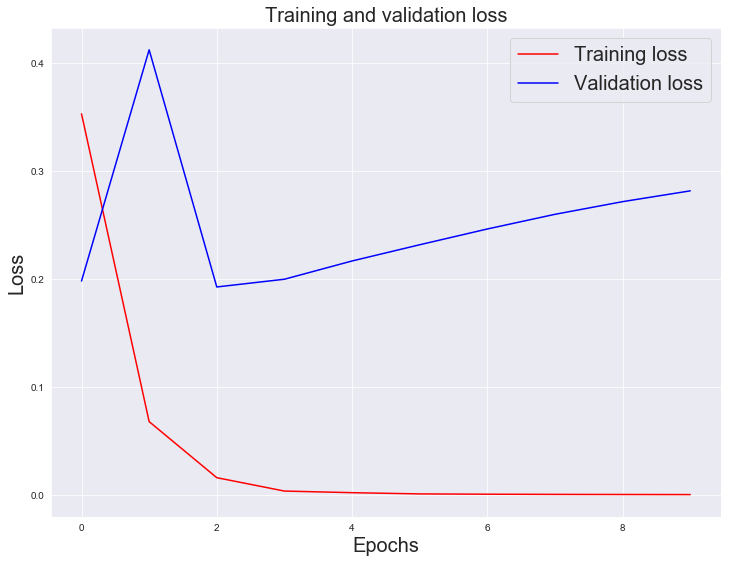

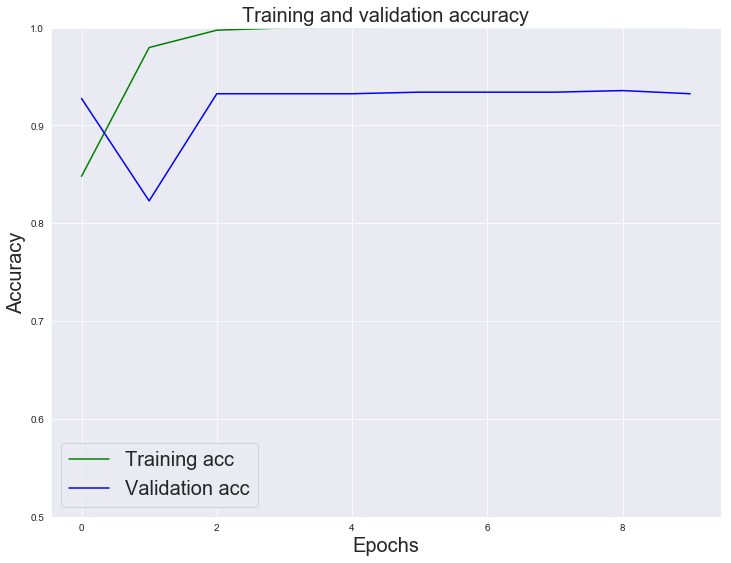

In [37]:
model_plot(model6_title_rnn)

In [38]:
# Define a function which can measure the macro_F1 score of RNN models
def rnn_f1(model, x_test_rnn):
    pred_prob = model.predict(x_test_rnn)
    pred = []
    
    for i in pred_prob:
        if i >= 0.5:
            pred.append(1)
        else:
            pred.append(0)
            
    f1_macro = f1_score(y_test, pred, average = 'macro')
    
    return f1_macro

In [39]:
f1_model6_title = rnn_f1(model6_title, x_test_title_rnn)
print('F1 score of model6_title_rnn: ', f1_model6_title)

F1 score of model6_title_rnn:  0.9102400242289066


# Model 7 : Simple RNN Model with Glove Embeddings Input

In [40]:
# Generate the embedding matrix for model building
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [41]:
model7_title = Sequential(name = 'model7_title_glove')
model7_title.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_title_length, weights=[embedding_matrix], trainable= False))
model7_title.add(SimpleRNN(32))
model7_title.add(Dense(1, activation = 'sigmoid'))
model7_title.summary()

Model: "model7_title_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1085900   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,090,189
Trainable params: 4,289
Non-trainable params: 1,085,900
_________________________________________________________________


In [42]:
model7_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7_title_rnn = model7_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model7_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 1s 4ms/step - loss: 0.4507 - accuracy: 0.7817 - val_loss: 0.3115 - val_accuracy: 0.8760
Epoch 2/10
175/175 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.8868 - val_loss: 0.2953 - val_accuracy: 0.8744
Epoch 3/10
175/175 [==============================] - 0s 3ms/step - loss: 0.2439 - accuracy: 0.9049 - val_loss: 0.3015 - val_accuracy: 0.8728
Epoch 4/10
175/175 [==============================] - 0s 3ms/step - loss: 0.2230 - accuracy: 0.9139 - val_loss: 0.2465 - val_accuracy: 0.8889
Epoch 5/10
175/175 [==============================] - 0s 3ms/step - loss: 0.2034 - accuracy: 0.9223 - val_loss: 0.3049 - val_accuracy: 0.8841
Epoch 6/10
175/175 [==============================] - 0s 3ms/step - loss: 0.1884 - accuracy: 0.9278 - val_loss: 0.2452 - val_accuracy: 0.8953
Epoch 7/10
175/175 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.9275 - val_loss: 0.2471 - val_accuracy: 0.8953
Epoch 

[0.2790793180465698, 0.8807989954948425]

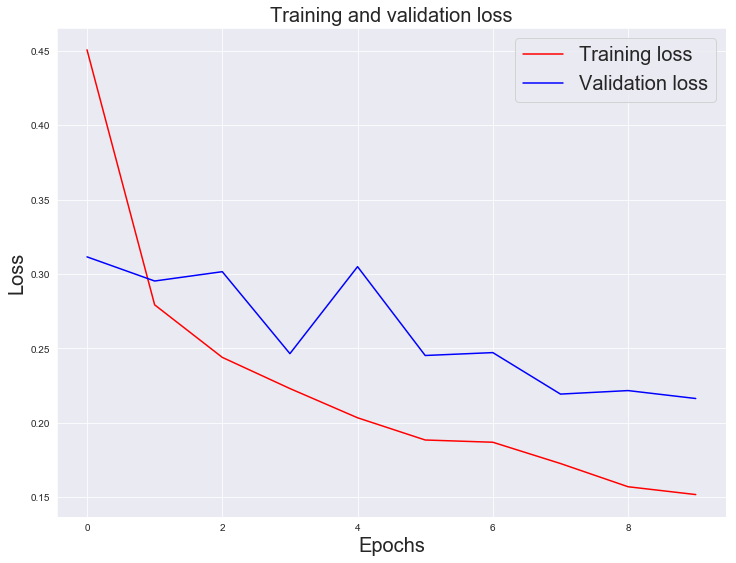

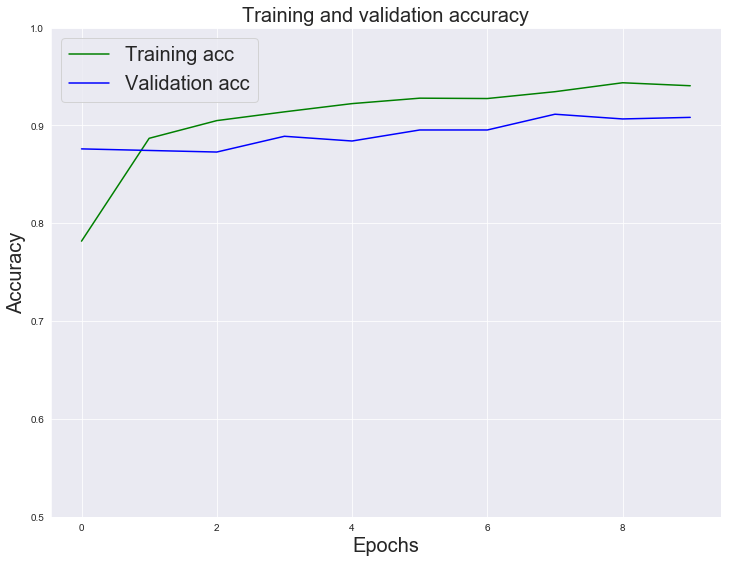

In [43]:
model_plot(model7_title_rnn)

In [44]:
f1_model7_title = rnn_f1(model7_title, x_test_title_rnn)
print('F1 score of model7_title_glove: ', f1_model7_title)

F1 score of model7_title_glove:  0.8711356284943218


# Model 8: Complex RNN Model with Glove Embedding Inputs

In [45]:
model8_title = Sequential(name = 'model8_title')
model8_title.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_title_length, weights=[embedding_matrix], trainable=False))
model8_title.add(Bidirectional(LSTM(64, dropout = 0.2, return_sequences=True)))
model8_title.add(Bidirectional(LSTM(16, return_sequences=False)))
model8_title.add(Dense(32, activation = 'relu'))
model8_title.add(Dropout(rate=0.5))
model8_title.add(Dense(1, activation = 'sigmoid'))
model8_title.summary()

Model: "model8_title"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           1085900   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,190,029
Trainable params: 104,129
Non-trainable params: 1,085,900
______________________________________

In [46]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model8_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model8_title_final = model8_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32,callbacks=[early_stop])
model8_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 5s 27ms/step - loss: 0.3951 - accuracy: 0.8297 - val_loss: 0.2327 - val_accuracy: 0.9050
Epoch 2/10
175/175 [==============================] - 4s 21ms/step - loss: 0.2543 - accuracy: 0.9069 - val_loss: 0.2012 - val_accuracy: 0.9195
Epoch 3/10
175/175 [==============================] - 4s 21ms/step - loss: 0.2035 - accuracy: 0.9269 - val_loss: 0.1766 - val_accuracy: 0.9259
Epoch 4/10
175/175 [==============================] - 4s 21ms/step - loss: 0.1821 - accuracy: 0.9345 - val_loss: 0.1687 - val_accuracy: 0.9340
Epoch 5/10
175/175 [==============================] - 4s 21ms/step - loss: 0.1689 - accuracy: 0.9386 - val_loss: 0.2260 - val_accuracy: 0.8953
Epoch 6/10
175/175 [==============================] - 4s 21ms/step - loss: 0.1384 - accuracy: 0.9500 - val_loss: 0.1670 - val_accuracy: 0.9404
Epoch 7/10
175/175 [==============================] - 4s 21ms/step - loss: 0.1246 - accuracy: 0.9568 - val_loss: 0.1535 - val_accuracy: 0.9372

[0.23009160161018372, 0.9085051417350769]

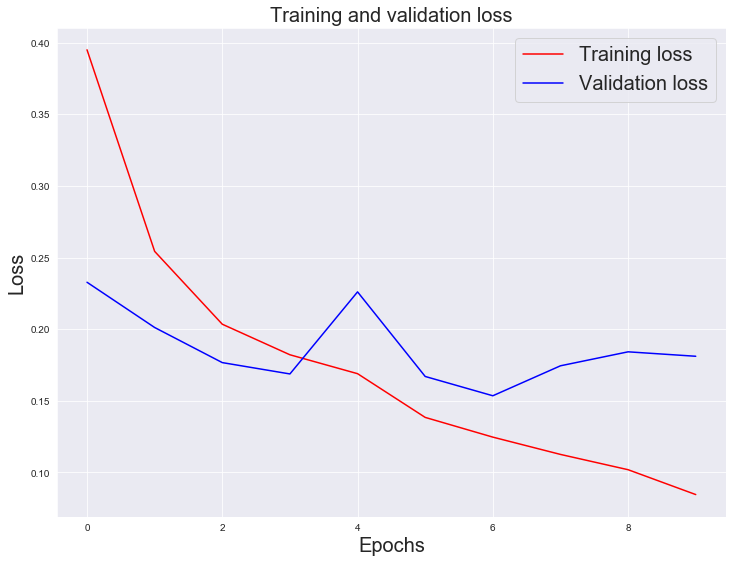

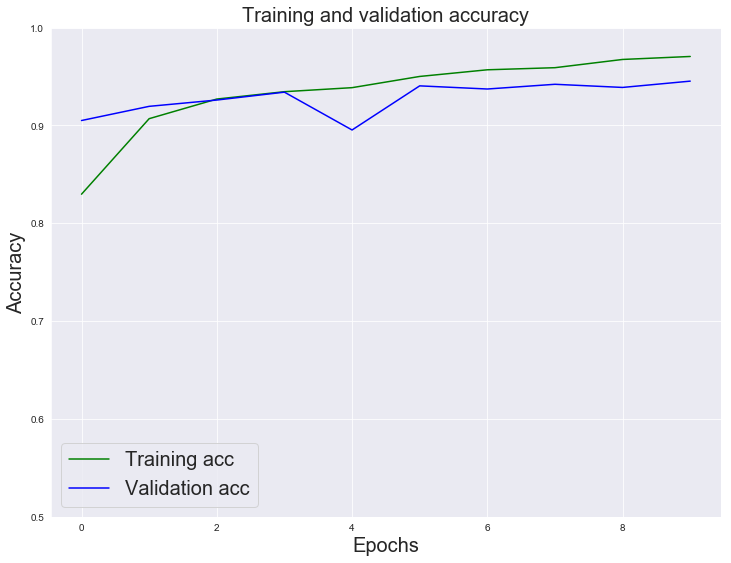

In [47]:
model_plot(model8_title_final)

In [48]:
f1_model8_title = rnn_f1(model8_title, x_test_title_rnn)
print('F1 score of model8_title: ', f1_model8_title)

F1 score of model8_title:  0.9017125731411446


In [49]:
# Summarize the predictions of models used in Part 1
Model_Name = ['NB with TF-IDF', 'Simple DNN with TF-IDF', 'Complex DNN with TF-IDF', 'Simple DNN with Glove', 'Complex DNN with Glove', 'Simple RNN with Self-embedding', 'Simple RNN with Glove', 'Complex RNN with Glove']

Averaged_F1_Score = [f1_model1_title,f1_model2_title,f1_model3_title,f1_model4_title,f1_model5_title,f1_model6_title, f1_model7_title,f1_model8_title]

Summary_title=pd.DataFrame({'Model Name':Model_Name, 'Macro Averaged F1 Score':Averaged_F1_Score})

Summary_title

,Model Name,Macro Averaged F1 Score
0,NB with TF-IDF,0.928129
1,Simple DNN with TF-IDF,0.943150
2,Complex DNN with TF-IDF,0.940624
3,Simple DNN with Glove,0.900929
4,Complex DNN with Glove,0.898317
5,Simple RNN with Self-embedding,0.910240
6,Simple RNN with Glove,0.871136
7,Complex RNN with Glove,0.901713


# 2. Prediction based on Text

# Model 1: Naive Bayes Model with TF-IDF Inputs

In [50]:
model1_text = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_text.fit(x_train_text, y_train)
pred1_text = model1_text.predict(x_test_text)
f1_model1_text = f1_score(y_test, pred1_text, average = 'macro')

print('F1 score of mode21_text: ', f1_model1_text)

F1 score of mode21_text:  0.6561700963251216


In [51]:
# To compare with the reference paper, we analyze the feature size of the tokens here
tokenizer = TfidfVectorizer()
x= tokenizer.fit_transform(x_train['text'])
x.shape

(6205, 57726)

Text(28.6, 0.5, 'predicted label')

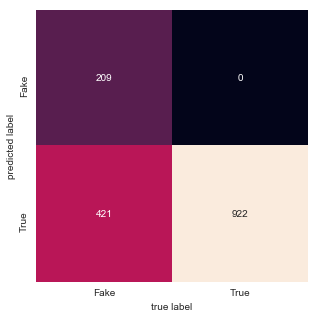

In [52]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_text)
label_name = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


# Model 2: Single Layer Neural Network Model with TF-IDF Inputs

In [53]:
model2_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_text.fit(x_train_text, y_train)

Iteration 1, loss = 0.60506918
Iteration 2, loss = 0.40863560
Iteration 3, loss = 0.25178339
Iteration 4, loss = 0.15828300
Iteration 5, loss = 0.10529325
Iteration 6, loss = 0.07376747
Iteration 7, loss = 0.05396829
Iteration 8, loss = 0.04103129
Iteration 9, loss = 0.03210281
Iteration 10, loss = 0.02582662
Iteration 11, loss = 0.02131203
Iteration 12, loss = 0.01790139
Iteration 13, loss = 0.01529733
Iteration 14, loss = 0.01324577
Iteration 15, loss = 0.01164221
Iteration 16, loss = 0.01032906
Iteration 17, loss = 0.00924273
Iteration 18, loss = 0.00835967
Iteration 19, loss = 0.00761715
Iteration 20, loss = 0.00700036
Iteration 21, loss = 0.00647684
Iteration 22, loss = 0.00601770
Iteration 23, loss = 0.00562620
Iteration 24, loss = 0.00528585
Iteration 25, loss = 0.00498615
Iteration 26, loss = 0.00471851
Iteration 27, loss = 0.00447823
Iteration 28, loss = 0.00426447
Iteration 29, loss = 0.00407562
Iteration 30, loss = 0.00390248
Iteration 31, loss = 0.00374778
Iteration 32, los

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False))])

In [54]:
pred2_text = model2_text.predict(x_test_text)
f1_model2_text = f1_score(y_test, pred2_text, average = 'macro')

print('F1 score of model2_text: ', f1_model2_text)


F1 score of model2_text:  0.9738057371355868


# Model 3: Multi-Layer Neural Network Model with TF-IDF Inputs

In [55]:
model3_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(200,200,200,200, ), random_state=1, verbose = True))
model3_text.fit(x_train_text, y_train)

Iteration 1, loss = 0.40584209
Iteration 2, loss = 0.01547529
Iteration 3, loss = 0.00123650
Iteration 4, loss = 0.00042198
Iteration 5, loss = 0.00036615
Iteration 6, loss = 0.00034236
Iteration 7, loss = 0.00032365
Iteration 8, loss = 0.00030848
Iteration 9, loss = 0.00029577
Iteration 10, loss = 0.00028466
Iteration 11, loss = 0.00027521
Iteration 12, loss = 0.00026625
Iteration 13, loss = 0.00025499
Iteration 14, loss = 0.00024492
Iteration 15, loss = 0.00023845
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False))])

In [56]:
pred3_text = model3_text.predict(x_test_text)
f1_model3_text = f1_score(y_test, pred3_text, average = 'macro')

print('F1 score of model3_text: ', f1_model3_text)


F1 score of model3_text:  0.9792013134920412


# Model 4 : Single Neural Network Model with Embeddings Inputs

In [57]:
x_train_text_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_train_text])
x_test_text_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_test_text])
#fit model
model4_text = MLPClassifier(hidden_layer_sizes=(50), max_iter=500,random_state=1,verbose=True)
model4_text.fit(x_train_text_embed, y_train)


Iteration 1, loss = 0.60260620
Iteration 2, loss = 0.47472773
Iteration 3, loss = 0.40469009
Iteration 4, loss = 0.37258317
Iteration 5, loss = 0.34717741
Iteration 6, loss = 0.33212068
Iteration 7, loss = 0.31652038
Iteration 8, loss = 0.30487866
Iteration 9, loss = 0.29418298
Iteration 10, loss = 0.28469136
Iteration 11, loss = 0.27823555
Iteration 12, loss = 0.26969209
Iteration 13, loss = 0.26259422
Iteration 14, loss = 0.25811264
Iteration 15, loss = 0.25598596
Iteration 16, loss = 0.25201360
Iteration 17, loss = 0.24367293
Iteration 18, loss = 0.24218454
Iteration 19, loss = 0.23592849
Iteration 20, loss = 0.23288662
Iteration 21, loss = 0.23097636
Iteration 22, loss = 0.22726877
Iteration 23, loss = 0.22646082
Iteration 24, loss = 0.22108128
Iteration 25, loss = 0.21837530
Iteration 26, loss = 0.21628394
Iteration 27, loss = 0.21398403
Iteration 28, loss = 0.21644299
Iteration 29, loss = 0.20912775
Iteration 30, loss = 0.20971840
Iteration 31, loss = 0.20629274
Iteration 32, los

Iteration 258, loss = 0.10388374
Iteration 259, loss = 0.10328370
Iteration 260, loss = 0.10318439
Iteration 261, loss = 0.10689026
Iteration 262, loss = 0.10361863
Iteration 263, loss = 0.10343371
Iteration 264, loss = 0.10198550
Iteration 265, loss = 0.10246671
Iteration 266, loss = 0.10444060
Iteration 267, loss = 0.10618736
Iteration 268, loss = 0.10242297
Iteration 269, loss = 0.10240972
Iteration 270, loss = 0.10472838
Iteration 271, loss = 0.10389200
Iteration 272, loss = 0.11393813
Iteration 273, loss = 0.10304930
Iteration 274, loss = 0.10227024
Iteration 275, loss = 0.11370661
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [58]:
pred4_text = model4_text.predict(x_test_text_embed)
f1_model4_text = f1_score(y_test, pred4_text, average = 'macro')
print('F1 score of model4_text: ', f1_model4_text)

F1 score of model4_text:  0.9405947832923258


# Model 5 : Multi-Layer Neural Network Model with Embeddings Inputs

In [59]:
#fit model
model5_text = MLPClassifier(hidden_layer_sizes=(200,200,200,200),random_state=1, max_iter=500,verbose=True)
model5_text.fit(x_train_text_embed, y_train)

Iteration 1, loss = 0.46206521
Iteration 2, loss = 0.29007331
Iteration 3, loss = 0.24771789
Iteration 4, loss = 0.21192535
Iteration 5, loss = 0.20942700
Iteration 6, loss = 0.19994150
Iteration 7, loss = 0.18074232
Iteration 8, loss = 0.20253200
Iteration 9, loss = 0.16720516
Iteration 10, loss = 0.19782872
Iteration 11, loss = 0.16471636
Iteration 12, loss = 0.14683464
Iteration 13, loss = 0.17515028
Iteration 14, loss = 0.14116613
Iteration 15, loss = 0.11803464
Iteration 16, loss = 0.11817462
Iteration 17, loss = 0.10925009
Iteration 18, loss = 0.11804335
Iteration 19, loss = 0.09865839
Iteration 20, loss = 0.21380051
Iteration 21, loss = 0.11156120
Iteration 22, loss = 0.13029346
Iteration 23, loss = 0.09659878
Iteration 24, loss = 0.09287273
Iteration 25, loss = 0.09776360
Iteration 26, loss = 0.08413248
Iteration 27, loss = 0.06673119
Iteration 28, loss = 0.16609174
Iteration 29, loss = 0.08383081
Iteration 30, loss = 0.08556640
Iteration 31, loss = 0.16746506
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [60]:
pred5_text = model5_text.predict(x_test_text_embed)
f1_model5_text = f1_score(y_test, pred5_text, average = 'macro')
print('F1 score of mode25_text: ', f1_model5_text)

F1 score of mode25_text:  0.9304072431813319


# Model 7 : Simple RNN Model with GLove Embeddings Input

In [61]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train['text'])
word_index = tokenizer.word_index

max_vocab = len(word_index) + 1

#Here we use 99 percentile length of the news text as the max_text_length to save computation load
len_text_arr = np.array(len_text)
max_text_length = int(np.percentile(len_text_arr, 99)) 


# tokenize the text into vectors 
x_train_text_rnn = tokenizer.texts_to_sequences(x_train_text)
x_test_text_rnn = tokenizer.texts_to_sequences(x_test_text)

#Apply padding so we have the same length for each article
x_train_text_rnn = pad_sequences(x_train_text_rnn, maxlen=max_text_length)
x_test_text_rnn = pad_sequences(x_test_text_rnn, maxlen=max_text_length)

In [62]:
# Generate the embedding matrix for model building
embedding_matrix = np.zeros((max_vocab, 100))
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [63]:
model7_text = Sequential(name = 'model7_text')
model7_text.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_text_length, weights=[embedding_matrix], trainable=False))
model7_text.add(SimpleRNN(32))
model7_text.add(Dense(1, activation = 'sigmoid'))
model7_text.summary()

Model: "model7_text"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 817, 100)          6603700   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,607,989
Trainable params: 4,289
Non-trainable params: 6,603,700
_________________________________________________________________


In [64]:
model7_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7_text_final = model7_text.fit(x_train_text_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model7_text.evaluate(x_test_text_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 15s 85ms/step - loss: 0.4438 - accuracy: 0.7921 - val_loss: 0.3701 - val_accuracy: 0.8422
Epoch 2/10
175/175 [==============================] - 14s 78ms/step - loss: 0.3294 - accuracy: 0.8680 - val_loss: 0.3289 - val_accuracy: 0.8760
Epoch 3/10
175/175 [==============================] - 13s 74ms/step - loss: 0.2953 - accuracy: 0.8831 - val_loss: 0.3162 - val_accuracy: 0.8857
Epoch 4/10
175/175 [==============================] - 13s 73ms/step - loss: 0.2709 - accuracy: 0.8945 - val_loss: 0.2899 - val_accuracy: 0.8857
Epoch 5/10
175/175 [==============================] - 13s 73ms/step - loss: 0.3119 - accuracy: 0.8671 - val_loss: 0.3713 - val_accuracy: 0.8341
Epoch 6/10
175/175 [==============================] - 13s 74ms/step - loss: 0.3184 - accuracy: 0.8616 - val_loss: 0.3651 - val_accuracy: 0.8422
Epoch 7/10
175/175 [==============================] - 13s 74ms/step - loss: 0.2849 - accuracy: 0.8791 - val_loss: 0.3176 - val_accuracy:

[0.30133306980133057, 0.8795102834701538]

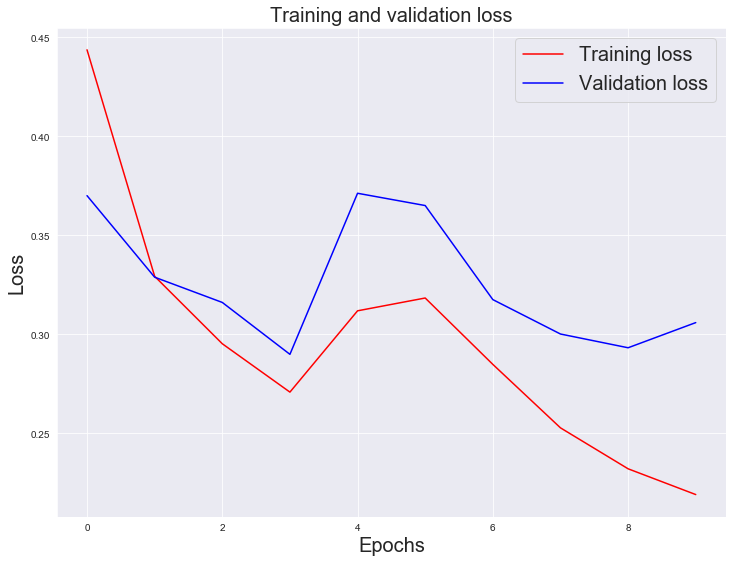

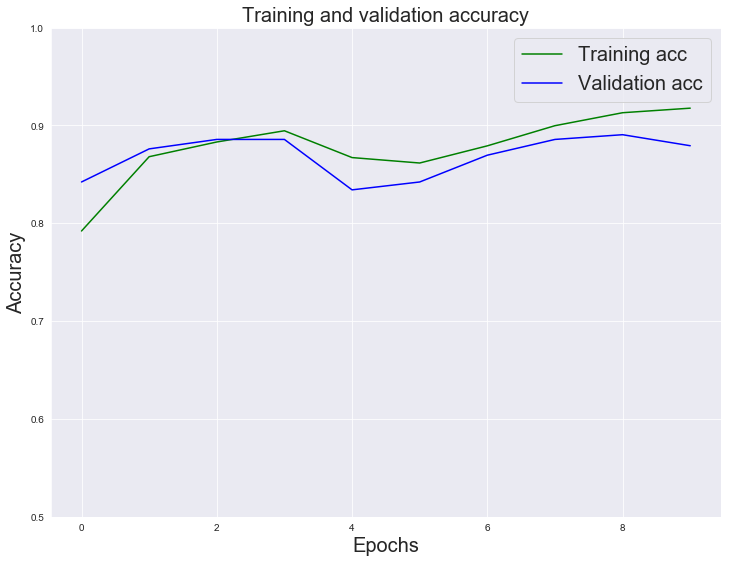

In [65]:
model_plot(model7_text_final)

In [66]:
f1_model7_text = rnn_f1(model7_text, x_test_text_rnn)
print('F1 score of model7_text: ', f1_model7_text)

F1 score of model7_text:  0.8757210643940319


# Model 8: Complex RNN Model with Glove Embedding Inputs

In [67]:
model8_text = Sequential(name = 'model8_text')
model8_text.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_text_length, weights=[embedding_matrix], trainable=False))
model8_text.add(Bidirectional(LSTM(64, dropout = 0.2, return_sequences=True)))
model8_text.add(Bidirectional(LSTM(16, return_sequences=False)))
model8_text.add(Dense(32, activation = 'relu'))
model8_text.add(Dropout(rate=0.5))
model8_text.add(Dense(1, activation = 'sigmoid'))
model8_text.summary()

Model: "model8_text"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 817, 100)          6603700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 817, 128)          84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 6,707,829
Trainable params: 104,129
Non-trainable params: 6,603,700
_______________________________________

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model8_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model8_text_final = model8_text.fit(x_train_text_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32,callbacks=[early_stop])
model8_text.evaluate(x_test_text_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 110s 631ms/step - loss: 0.4613 - accuracy: 0.7960 - val_loss: 0.3306 - val_accuracy: 0.8776
Epoch 2/10
175/175 [==============================] - 108s 619ms/step - loss: 0.2955 - accuracy: 0.8931 - val_loss: 0.2291 - val_accuracy: 0.9163
Epoch 3/10
175/175 [==============================] - 107s 611ms/step - loss: 0.2163 - accuracy: 0.9259 - val_loss: 0.1654 - val_accuracy: 0.9501
Epoch 4/10
175/175 [==============================] - 107s 611ms/step - loss: 0.1807 - accuracy: 0.9384 - val_loss: 0.1842 - val_accuracy: 0.9308
Epoch 5/10
175/175 [==============================] - 108s 617ms/step - loss: 0.1666 - accuracy: 0.9447 - val_loss: 0.1439 - val_accuracy: 0.9501
Epoch 6/10
175/175 [==============================] - 105s 603ms/step - loss: 0.1340 - accuracy: 0.9549 - val_loss: 0.1186 - val_accuracy: 0.9549
Epoch 7/10
175/175 [==============================] - 105s 603ms/step - loss: 0.1309 - accuracy: 0.9540 - val_loss: 0.1215 -

[0.1457371711730957, 0.9555412530899048]

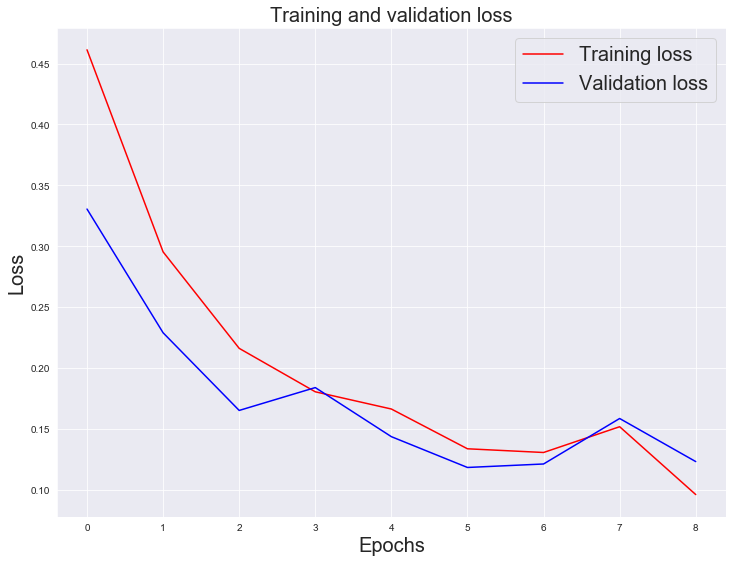

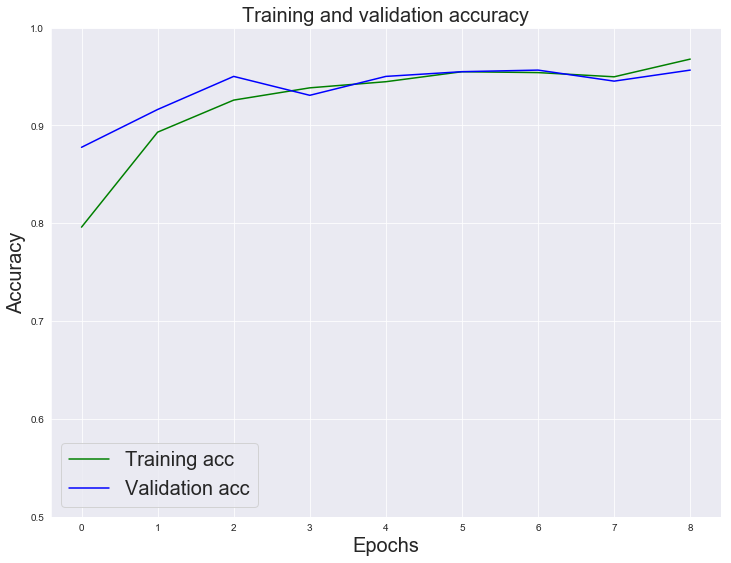

In [69]:
model_plot(model8_text_final)

In [70]:
f1_model8_text = rnn_f1(model8_text, x_test_text_rnn)
print('F1 score of f1_model8_text: ', f1_model8_text)

F1 score of f1_model8_text:  0.953706149385511


In [71]:
# Summarize the predictions of models used in Part 2
Model_Name2 = ['NB with TF-IDF', 'Simple DNN with TF-IDF', 'Complex DNN with TF-IDF', 'Simple DNN with Glove', 'Complex DNN with Glove', 'Simple RNN with Glove', 'Complex RNN with Glove']

Averaged_F1_Score2 = [f1_model1_text,f1_model2_text,f1_model3_text,f1_model4_text,f1_model5_text, f1_model7_text,f1_model8_text]

Summary_text=pd.DataFrame({'Model Name':Model_Name2, 'Macro Averaged F1 Score':Averaged_F1_Score2})

Summary_text

,Model Name,Macro Averaged F1 Score
0,NB with TF-IDF,0.656170
1,Simple DNN with TF-IDF,0.973806
2,Complex DNN with TF-IDF,0.979201
3,Simple DNN with Glove,0.940595
4,Complex DNN with Glove,0.930407
5,Simple RNN with Glove,0.875721
6,Complex RNN with Glove,0.953706


In [72]:
Summary_title

,Model Name,Macro Averaged F1 Score
0,NB with TF-IDF,0.928129
1,Simple DNN with TF-IDF,0.943150
2,Complex DNN with TF-IDF,0.940624
3,Simple DNN with Glove,0.900929
4,Complex DNN with Glove,0.898317
5,Simple RNN with Self-embedding,0.910240
6,Simple RNN with Glove,0.871136
7,Complex RNN with Glove,0.901713
